In [2]:
%pylab inline
from sklearn.neural_network import MLPRegressor
import bilby
import redback
import pandas as pd
from bilby.core.prior import Constraint, PriorDict, Uniform
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from redback.transient_models.afterglow_models import tophat
from sklearn import preprocessing as pre
import scipy.constants as const
from sklearn.model_selection import GridSearchCV

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [94]:
def line(x, m, c, **kwargs):
    return m*x+c

prior = bilby.core.prior.PriorDict()
prior['m'] = bilby.core.prior.Uniform(3, 8, 'm')
prior['c'] = bilby.core.prior.Uniform(-2, 2, 'c')

In [95]:
xs = np.linspace(1, 20, 50)
models = 100
ys = np.zeros((models, len(xs)))
samples = pd.DataFrame(prior.sample(models))

In [96]:
for ii in range(models):
    ys[ii] = line(xs, **samples.iloc[ii].to_dict())
    plt.plot(xs, ys[ii], color='red', alpha=0.05)

In [97]:
X_train = samples.values
y_train = ys
regr = MLPRegressor(random_state=1, max_iter=5000).fit(X_train, y_train)

In [49]:
y_pred = regr.predict(np.array([4, -1]).reshape(1, -1))
print(y_pred.shape)

(1, 50)


In [48]:
y_true = line(xs, 4, -1)

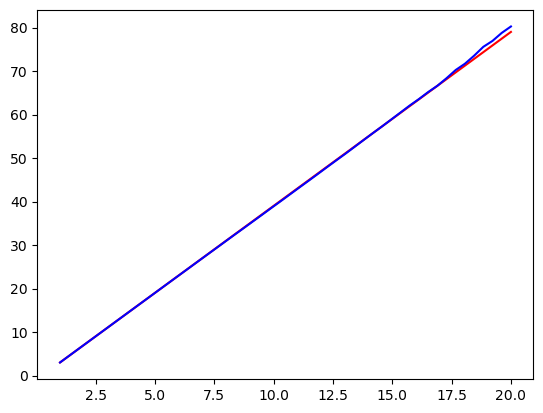

In [50]:
plt.plot(xs, y_true, color='red')
plt.plot(xs, y_pred[0,:], color='blue')

In [2]:
def afterglow(time, redshift,  thv, loge0 , thc, logn0, p, logepse, logepsb, ksin, g0, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', redshift=redshift,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=ksin, g0=g0, frequency= frequency)
    return ag_fluxd


In [3]:
def afterglow_constraints(parameters):
    constrained_params= parameters.copy()
    
    time=np.linspace(0.1,300,300) #make sure time arrays match
    maxflux=[]
    peaktime=[]
    minflux=[]
    for i in range(len(parameters['thv'])):
        flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
            base_model='tophat',  thv= parameters['thv'][i], loge0=parameters['loge0'][i] , thc=parameters['thc'][i], logn0=parameters['logn0'][i], 
            p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1.0, g0=1000,
            output_format='flux_density', frequency=1146839759677006.2)
        maxflux.append(max(flux))
        peaktime.append(time[np.argmax(flux)])
        fluxday1= np.interp(1,time,flux)
        minflux.append(fluxday1)
        
    #peak flux must be at times < 200 days
    constrained_params['peak_time']= 200 - np.array(peaktime)
    #peak flux must be greater than 10e-12
    constrained_params['max_flux']= np.array(maxflux) - (10e-12)
    #thv must be greater than thc
    constrained_params['valid_jet']= parameters['thv'] - parameters['thc']
    #filter on axis results (comment out if needed)
    #constrained_params['onaxis']= 0.05 - parameters['thv']
    #filter lower flux afterglows out for ON AXIS case (comment out if needed)
    #constrained_params['min_flux']= np.array(minflux) - 10e-7
    #filter off axis results (comment out if needed)
    constrained_params['offaxis']= parameters['thv'] - 0.06
    return constrained_params

In [2]:
priors = PriorDict(conversion_function=afterglow_constraints)
priors['max_flux']= Constraint(minimum=0, maximum=20)
priors['peak_time']= Constraint(minimum=0, maximum=250)
#priors['onaxis']= Constraint(minimum=0, maximum=0.05)
#priors['min_flux']=Constraint(minimum=0, maximum=10)
priors['offaxis']= Constraint(minimum=0.06, maximum=(np.pi)/2)
priors.update(redback.priors.get_priors(model='tophat'))
priors['p']=  2.3
priors['loge0']= Uniform(minimum=46, maximum=53, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
priors['redshift']= 0.01
priors['logepse']= -1.25
priors['logepsb']= -2.5
priors['ksin']= 1.0
priors['g0']= 1000
priors['frequency']= Uniform(minimum=5e9, maximum=2e17, name='frequency', latex_label='$frequency$', unit=None, boundary=None)

num=10000
samples=priors.sample(num)
afterglow_data=pd.DataFrame.from_dict(samples)

NameError: name 'afterglow_constraints' is not defined

In [269]:
time = np.linspace(0.1, 300, 600) #xs
yvals = np.zeros((num, len(time)))  #ys

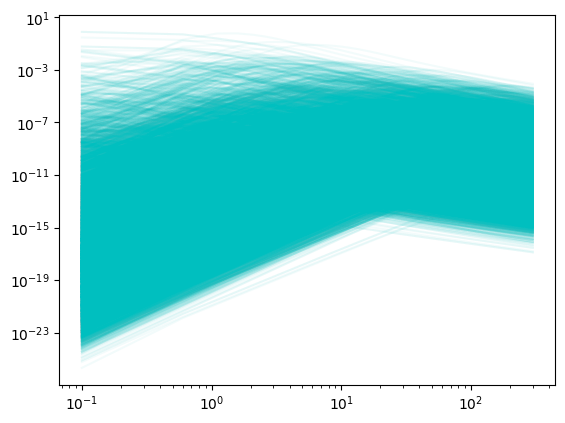

In [270]:
ax= plt.subplot()

for i in range(num):
    yvals[i]= afterglow(time, **afterglow_data.iloc[i])
    ax.loglog(time, yvals[i], color='c', alpha=0.05)
plt.show()

In [290]:
X = afterglow_data.values
Y = yvals
regr = MLPRegressor(random_state=7, max_iter=7000, hidden_layer_sizes=(200,),activation='logistic',solver='sgd', learning_rate='adaptive').fit(X, Y)

In [291]:
params=np.array([0.01, 0.5, 50.0 , 0.02, 1, 2.13,-1.25, -2.5, 1, 1000, 4e14])
prediction = regr.predict(params.reshape(1,-1))
prediction.shape

(1, 600)

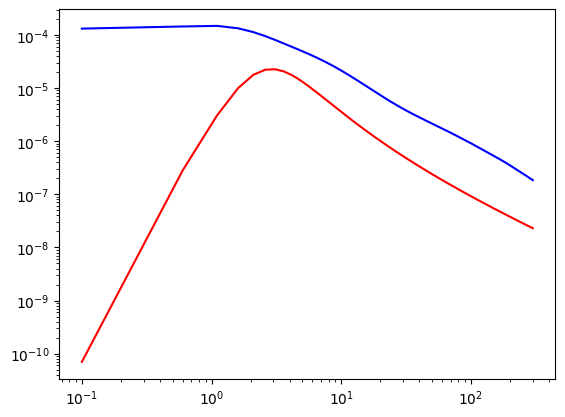

In [292]:
test_params= dict(redshift=0.01,  thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000,
     frequency= 4e14)
true_value= afterglow(time, **test_params)
ax1=plt.subplot()
ax1.loglog(time, true_value, color='red')
ax1.loglog(time, prediction[0,:], color='blue')#, ls='None', marker='x')
plt.show()

In [3]:
def tophat_func(time,  thv, loge0 , thc, logn0, p, logepse, logepsb, g0,frequency):
    flux= tophat(time=time, output_format='flux_density', redshift=0.01,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=1, g0=g0, frequency= frequency)
    return flux

In [5]:
general_priors= redback.priors.get_priors(model='tophat')
general_priors['frequency']= Uniform(minimum=1e8, maximum=5e17, name='frequency', latex_label='$frequency$', unit=None, boundary=None)
general_priors

num=100000
tnum=100
samples=general_priors.sample(num)
tophat_data=pd.DataFrame.from_dict(samples)
unprocessed= pd.DataFrame.from_dict(samples)
tophat_data.drop('redshift', axis=1,inplace=True)
tophat_data.drop('ksin', axis=1,inplace=True)
unprocessed.drop('redshift', axis=1,inplace=True)
unprocessed.drop('ksin', axis=1,inplace=True)

tophat_data['thv']=np.log10(tophat_data['thv'])
tophat_data['thc']=np.log10(tophat_data['thc'])
tophat_data['g0']=np.log10(tophat_data['g0'])
tophat_data['frequency']=np.log10(tophat_data['frequency'])

min(unprocessed['frequency'])

533790173836.0421

In [6]:
training = tophat_data.iloc[:(num-tnum)]
testing = tophat_data.iloc[(num-tnum):]


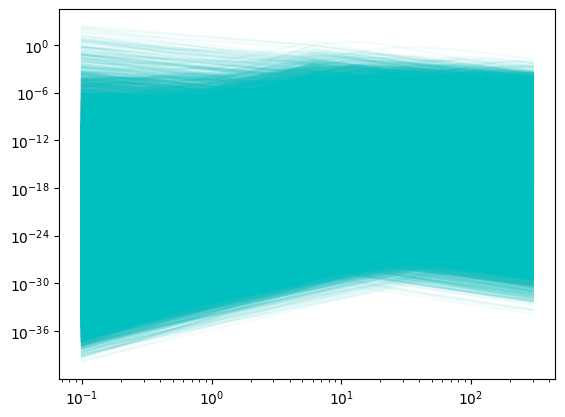

In [7]:
time = np.linspace(0.1, 300, 50) #xs
ys = np.zeros((num-tnum, len(time)))  #ys

ax= plt.subplot()

for i in range(num-tnum):
    ys[i]= tophat_func(time, **unprocessed.iloc[i])
    ax.loglog(time, ys[i], color='c', alpha=0.05)
plt.show()

In [8]:
scalerx = pre.StandardScaler()
scalery = pre.StandardScaler()
Y_train = scalery.fit_transform(np.log10(ys))
X_train = scalerx.fit_transform(training.values)
X_test= scalerx.transform(testing.values)

#params=np.array([0.5, 50.0 , 0.02, 1, 2.13,-1.25,-2.5, 1000])
#prediction = regr.predict(params.reshape(1,-1))


In [9]:
regr = MLPRegressor(random_state=7, max_iter=1000, hidden_layer_sizes=(800,800,800), activation='relu',solver='adam',learning_rate='adaptive',
                   learning_rate_init=1e-4, batch_size=64).fit(X_train, Y_train)

In [10]:
prediction = regr.predict(X_test)
prediction = 10**(scalery.inverse_transform(prediction))
prediction.shape

(100, 50)

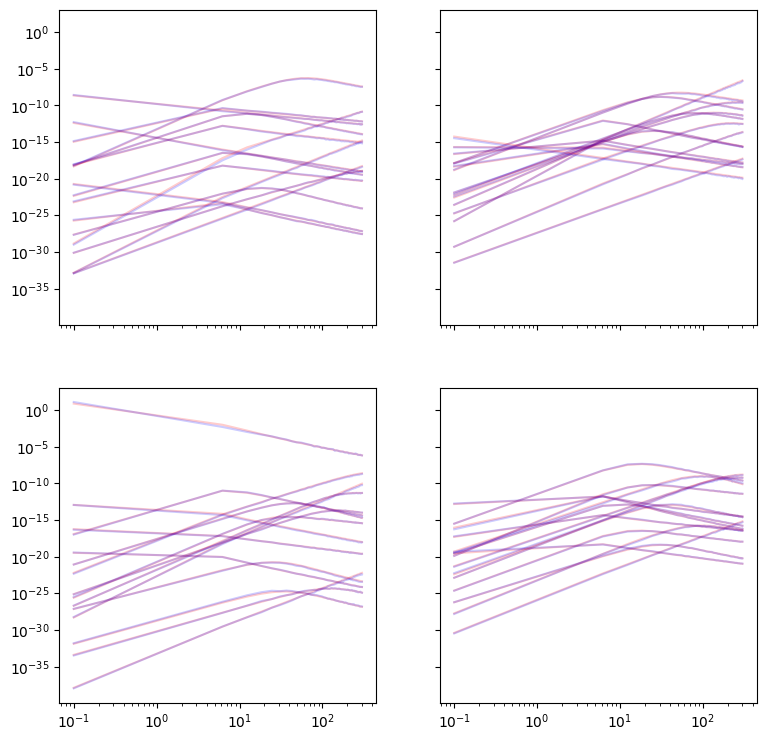

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9), sharex=True, sharey=True)
time = np.linspace(0.1, 300, 50) #xs
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)

for i in range(15): 
    true_value= tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[0,0].loglog(time, true_value, color='red', alpha=0.2)
    ax[0,0].loglog(time, prediction[i], color='blue', alpha=0.2)
for i in range(15,30): 
    true_value= tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[0,1].loglog(time, true_value, color='red', alpha=0.2)
    ax[0,1].loglog(time, prediction[i], color='blue', alpha=0.2)
for i in range(30,45): 
    true_value= tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[1,0].loglog(time, true_value, color='red', alpha=0.2)
    ax[1,0].loglog(time, prediction[i], color='blue', alpha=0.2)
for i in range(45,60): 
    true_value= tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[1,1].loglog(time, true_value, color='red', alpha=0.2)
    ax[1,1].loglog(time, prediction[i], color='blue', alpha=0.2)
    
#plt.savefig("emulation3k_3x800.png", dpi='figure')
plt.show()

In [73]:
print(regr.n_iter_, regr.best_loss_)

73 0.005612029467075825


In [11]:
print(regr.n_iter_, regr.best_loss_)

38 0.0013669637969929973


In [14]:
print(regr.n_iter_, regr.best_loss_, regr.t_)

10 0.0014232664780402901 999000


In [12]:
param_grid={}
param_grid['hidden_layer_sizes']=[(500,500,500), (800,800,800)]
param_grid['activation']=['tanh','relu', 'logistic']
param_grid['solver']=['adam','sgd']
param_grid['batch_size']=[64, 128]
param_grid['learning_rate_init']=[0.001, 1e-4]

In [13]:
mlp = MLPRegressor(random_state=7, max_iter=1000)
tuner = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, verbose=3, pre_dispatch=3)
tuner.fit(X_train, Y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 2/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=adam;, score=0.996 total time= 1.5min
[CV 3/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=adam;, score=0.997 total time= 1.8min
[CV 1/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=sgd;, score=0.997 total time= 1.3min
[CV 2/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=sgd;, score=0.997 total time= 1.2min
[CV 3/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=sgd;, score=0.997 total time= 1.2min
[CV 2/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.0001, solver=sgd;, score=0.993 total time= 4.0min
[CV 1/3] END activation=tanh,

GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=1000, random_state=7),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'batch_size': [64, 128],
                         'hidden_layer_sizes': [(500, 500, 500),
                                                (800, 800, 800)],
                         'learning_rate_init': [0.001, 0.0001],
                         'solver': ['adam', 'sgd']},
             pre_dispatch=3, verbose=3)

In [20]:
tuner.best_score_

0.9987270022686235

In [19]:
tuner.best_params_

{'activation': 'relu',
 'batch_size': 64,
 'hidden_layer_sizes': (800, 800, 800),
 'learning_rate_init': 0.0001,
 'solver': 'adam'}

In [76]:
def power(frequency, g0, logepsb, logn0):
    me= const.m_e
    mp= const.m_p
    c= const.c
    sigma = const.sigma
    q=const.e
    n0= 10**(logn0)
    epsb= 10**(logepsb)
    constant = (me*(c**3)*sigma*((32*np.pi*mp)**0.5))/(3*q)

    pow= constant*(g0**2)*((epsb*n0)**0.5)*frequency*10e7 #power in ergs
    return pow

In [77]:
pprior = bilby.core.prior.PriorDict()
pprior['g0'] = bilby.core.prior.Uniform(100, 2000, 'g0')
pprior['logepsb'] = bilby.core.prior.Uniform(-5, 0, 'c')
pprior['logn0']=bilby.core.prior.Uniform(-5,2,'logn0')
pprior

{'g0': Uniform(minimum=100, maximum=2000, name='g0', latex_label='g0', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='c', latex_label='c', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='logn0', unit=None, boundary=None)}

In [78]:
N= 5000
samples=pprior.sample(N)
power_data=pd.DataFrame.from_dict(samples)
power_data

,g0,logepsb,logn0
0,185.380307,-2.711978,0.601665
1,1423.031101,-4.650265,1.992532
2,394.884171,-0.541732,-1.991962
3,1221.158402,-4.845642,1.404221
4,415.062706,-3.860507,-4.259996
...,...,...,...
4995,944.116862,-2.469384,-2.699051
4996,1360.925225,-1.993366,0.738621
4997,959.389273,-3.519324,1.084934
4998,797.601144,-0.752727,-0.088104


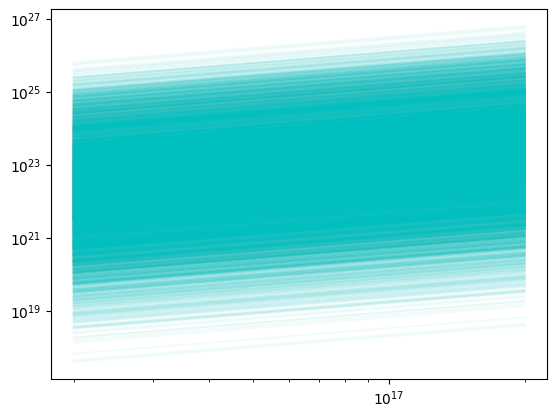

In [188]:
frequency = np.linspace(2e16, 2e17, 500) #xs
y = np.zeros((4900, len(frequency)))  #ys  

ax= plt.subplot()
for i in range(4900):
    y[i]= power(frequency, **power_data.iloc[i])
    ax.loglog(frequency, y[i], color='c', alpha=0.05)
plt.show()

In [196]:
y_train= y
scaler = pre.StandardScaler()
x_train=power_data.iloc[:4900].values
scaler.fit(x_train)  
x_train = scaler.transform(x_train) 

x_test=power_data.iloc[4900:].values
x_test = scaler.transform(x_test)

regress = MLPRegressor(random_state=7, max_iter=2000, hidden_layer_sizes=(100,), activation='tanh',solver='sgd',learning_rate='adaptive', 
                       learning_rate_init=1e-5, batch_size= 16).fit(x_train, y_train)

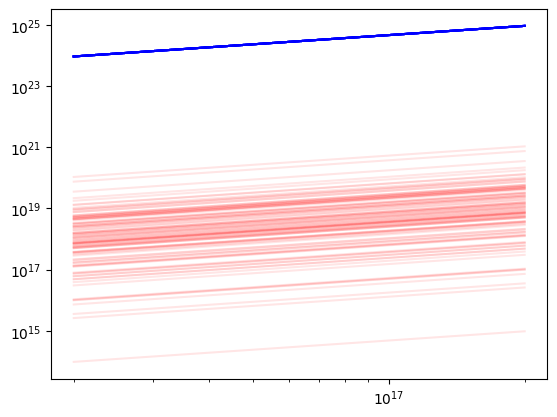

In [197]:
prediction = regress.predict(x_test)
#print(prediction)
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)
ax2=plt.subplot()
for i in range(100): 
    true_value= power(frequency, *x_test[i])
    ax2.loglog(frequency, true_value, color='red', alpha=0.1)
    ax2.loglog(frequency, prediction[i], color='blue', alpha=0.1)# ls='None', marker='x')
    #print(regr.score(testing.values[i].reshape(1,-1),true_value.reshape(1,-1)))
#plt.ylim(10e22,10e25)
plt.show()